In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Download the preprocessed files with complexity features for REALEC essays and get rid of unnecessary columns.

In [0]:
rlc2 = pd.read_excel('/content/drive/My Drive/rlc_proc_marks70.xlsx')
nrlc_drop = rlc2.drop('Unnamed: 0', axis=1)
nrlc_drop = nrlc_drop.drop('Unnamed: 0.1', axis=1)
nrlc_drop = nrlc_drop.drop('date', axis=1)
nrlc_drop = nrlc_drop.drop('department', axis=1)
nrlc_drop = nrlc_drop.drop('ielts', axis=1)
nrlc_drop = nrlc_drop.drop('Text', axis=1)
nrlc_drop = nrlc_drop.drop('sex', axis=1)
nrlc_drop = nrlc_drop.drop('study_year', axis=1)
nrlc_drop = nrlc_drop.drop('text_type', axis=1)
nrlc_drop = nrlc_drop.drop('work_type', axis=1)
nrlc_drop = nrlc_drop.drop('Folder', axis=1)
rlc_3 = nrlc_drop.copy()

Here we transform REALEC grades into corresponding CEFR levels


In [10]:
for i in rlc_3.index.values.tolist():
    if rlc_3.loc[i, 'mark'] < 50:
        rlc_3.loc[i, 'mark'] = 'C'
    elif rlc_3.loc[i, 'mark'] >= 50 and rlc_3.loc[i, 'mark'] <= 60:
        rlc_3.loc[i, 'mark'] = 'B'
    elif rlc_3.loc[i, 'mark'] > 60:
        rlc_3.loc[i, 'mark'] = 'A'
mark = []
for i in rlc_3['mark']:
    mark.append(i)
print(collections.Counter(mark))

Counter({'B': 1831, 'A': 879, 'C': 152})


Split our data into train and test subsets and add a random feature

In [0]:
columns = rlc_3.columns[1:]
X = rlc_3[columns]
X['random'] = np.random.random(size = len(X))
y = rlc_3['mark']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
!pip install catboost
from catboost import CatBoostClassifier, Pool

     |████████████████████████████████| 64.8MB 61kB/s 


**66 complexity features, REALEC data**

Confusion Matrix:
[[ 74 187   0]
 [ 35 513   7]
 [  0  20  23]]
Classification Report
              precision    recall  f1-score   support

           A       0.68      0.28      0.40       261
           B       0.71      0.92      0.80       555
           C       0.77      0.53      0.63        43

    accuracy                           0.71       859
   macro avg       0.72      0.58      0.61       859
weighted avg       0.71      0.71      0.67       859



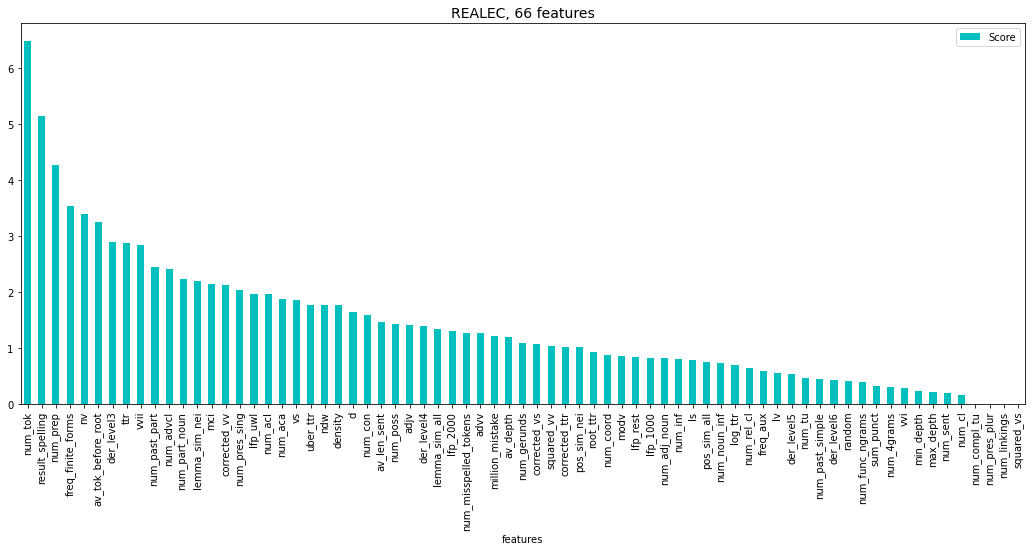

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 156,
    depth = 5,
    learning_rate=0.2,
    l2_leaf_reg = 0.5,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
);
predictions = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))
fi = model.get_feature_importance(Pool(X_test, label=y_test))
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )), columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (18,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("REALEC, 66 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**41 features, REALEC data**

Confusion Matrix:
[[ 82 179   0]
 [ 45 505   5]
 [  1  20  22]]
Classification Report
              precision    recall  f1-score   support

           A       0.64      0.31      0.42       261
           B       0.72      0.91      0.80       555
           C       0.81      0.51      0.63        43

    accuracy                           0.71       859
   macro avg       0.72      0.58      0.62       859
weighted avg       0.70      0.71      0.68       859



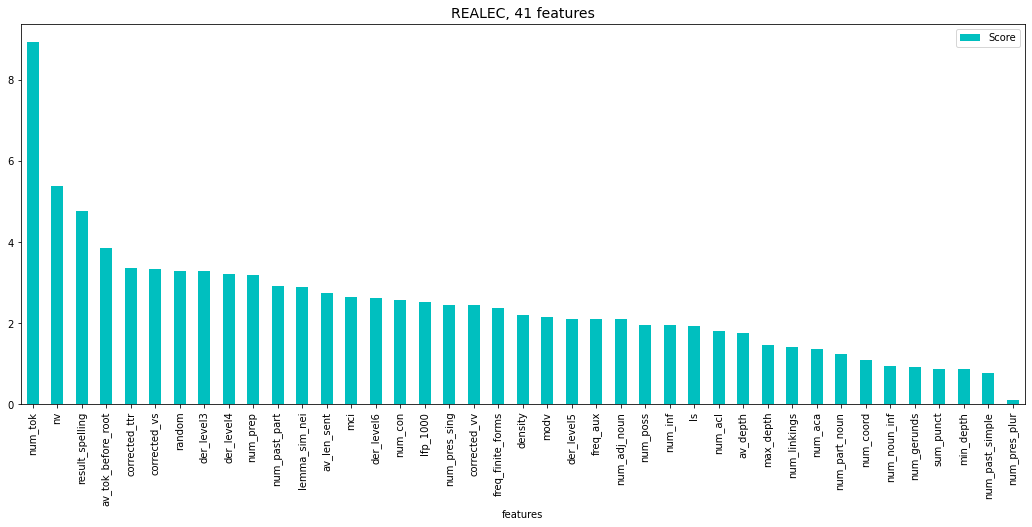

In [118]:
removed = ['lv',  'num_rel_cl','num_advcl','pos_sim_nei','pos_sim_all', 'lemma_sim_all', 'lfp_2000', 
           'lfp_rest', 'adjv', 'advv', 'num_4grams', 'ttr', 'root_ttr', 'log_ttr', 'uber_ttr', 'd',
           'vvi', 'squared_vv', 'vvii', 'lfp_uwl', 'vs', 'squared_vs','num_tu','num_compl_tu','num_misspelled_tokens','million_mistake',
           'num_sent', 'ndw', 'num_cl', 'num_func_ngrams']
for i in removed:
  X = X.drop(i, 1)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 156,
    depth = 6,
    learning_rate = 0.1,
    l2_leaf_reg = 0.5,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_d, y_train_d,
    eval_set=(X_test_d, y_test_d),
);
predictions = model.predict(X_test_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_d, predictions))
print("Classification Report")
print(classification_report(y_test_d, predictions))

fi = model.get_feature_importance(Pool(X_test_d, label=y_test_d))
feature_score = pd.DataFrame(list(zip(X_test_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (18,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("REALEC, 41 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**5 features, REALEC data**

Confusion Matrix:
[[ 58 203   0]
 [ 40 508   7]
 [  0  22  21]]
Classification Report
              precision    recall  f1-score   support

           A       0.59      0.22      0.32       261
           B       0.69      0.92      0.79       555
           C       0.75      0.49      0.59        43

    accuracy                           0.68       859
   macro avg       0.68      0.54      0.57       859
weighted avg       0.67      0.68      0.64       859



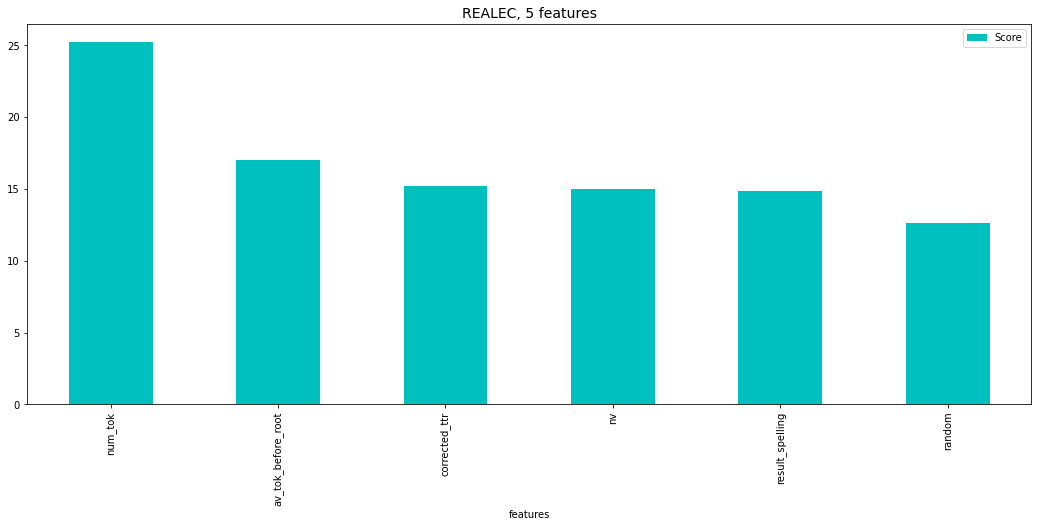

In [119]:
best = ['num_tok','result_spelling','av_tok_before_root','nv','corrected_ttr', 'random']
for i in X.columns:
  if i not in best:
    X = X.drop(i, 1)
X_train_d, X_test_d, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 96,
    depth = 9,
    learning_rate = 0.05,
    l2_leaf_reg = 1,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_d, y_train,
    eval_set=(X_test_d, y_test),
);
predictions = model.predict(X_test_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("Classification Report")
print(classification_report(y_test, predictions))

fi = model.get_feature_importance(Pool(X_test_d, label=y_test_d))
feature_score = pd.DataFrame(list(zip(X_test_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (18,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("REALEC, 5 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**1 feature, REALEC data**

In [103]:
best = ['num_tok']
for i in X.columns:
  if i not in best:
    X = X.drop(i, 1)
X_train_d, X_test_d, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 96,
    depth = 9,
    learning_rate = 0.05,
    l2_leaf_reg = 1,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_d, y_train,
    eval_set=(X_test_d, y_test),
);
predictions = model.predict(X_test_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[ 44 217   0]
 [ 32 512  11]
 [  0  19  24]]
Classification Report
              precision    recall  f1-score   support

           A       0.58      0.17      0.26       261
           B       0.68      0.92      0.79       555
           C       0.69      0.56      0.62        43

    accuracy                           0.68       859
   macro avg       0.65      0.55      0.55       859
weighted avg       0.65      0.68      0.62       859



Download and process EfCamDat data of levels 7-16. Split the data into two groups: those produces by Russian students and the rest

In [0]:
ef1 = pd.read_excel('/content/drive/My Drive/efcamdat_proc70.xlsx')
ef_low = pd.read_excel('/content/drive/My Drive/efcamdat_proc_low.xlsx')
ef_full = pd.concat([ef1, ef_low], ignore_index=True)
ef = ef_full[ef_full['level'] != 16]
ef_ru = ef.loc[ef['nation'] == 'ru']
ef_other = ef.loc[ef['nation'] != 'ru']
ef_other = ef_other.drop('Unnamed: 0', axis=1)
ef_other = ef_other.drop('Unnamed: 0.1', axis=1)
ef_other = ef_other.drop('id', axis=1)
ef_other = ef_other.drop('grade', axis=1)
ef_other = ef_other.drop('topic', axis=1)
ef_other = ef_other.drop('date', axis=1)
ef_other = ef_other.drop('learner_id', axis=1)
ef_other = ef_other.drop('nation', axis=1)
ef_other = ef_other.drop('text', axis=1)
ef_ru = ef_ru.drop('Unnamed: 0', axis=1)
ef_ru = ef_ru.drop('Unnamed: 0.1', axis=1)
ef_ru = ef_ru.drop('id', axis=1)
ef_ru = ef_ru.drop('grade', axis=1)
ef_ru = ef_ru.drop('topic', axis=1)
ef_ru = ef_ru.drop('date', axis=1)
ef_ru = ef_ru.drop('learner_id', axis=1)
ef_ru = ef_ru.drop('nation', axis=1)
ef_ru = ef_ru.drop('text', axis=1)

Transorm grades from 16-grade scale into corresponding CEFR levels

In [54]:
for i in tqdm(ef_ru.index.values.tolist()):
      if ef_ru.loc[i, 'level'] < 10: 
        ef_ru.loc[i, 'level'] = 'B1'
      elif ef_ru.loc[i, 'level'] < 13 and ef_ru.loc[i, 'level'] > 9:
        ef_ru.loc[i, 'level'] = 'B2'
      elif ef_ru.loc[i, 'level'] < 16 and ef_ru.loc[i, 'level'] > 12:
        ef_ru.loc[i, 'level'] = 'C1'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [55]:
for i in tqdm(ef_other.index.values.tolist()):
      if ef_other.loc[i, 'level'] < 10: 
        ef_other.loc[i, 'level'] = 'B1'
      elif ef_other.loc[i, 'level'] < 13 and ef_other.loc[i, 'level'] > 9:
        ef_other.loc[i, 'level'] = 'B2'
      elif ef_other.loc[i, 'level'] < 16 and ef_other.loc[i, 'level'] > 12:
        ef_other.loc[i, 'level'] = 'C1'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Split the data into train and test subsets and add a random feature

In [0]:
columns = ef_ru.columns[1:]
X_ru = ef_ru[columns]
X_ru['random'] = np.random.random(size = len(X_ru))
y_ru = ef_ru['level']
X_train_ru, X_test_ru, y_train_ru, y_test_ru = train_test_split(X_ru, y_ru, test_size=0.3, random_state=42)
X_oth = ef_other[columns]
X_oth['random'] = np.random.random(size = len(X_oth))
y_oth = ef_other['level']
X_train_oth, X_test_oth, y_train_oth, y_test_oth = train_test_split(X_oth, y_oth, test_size=0.3, random_state=42)

**66 complexity features, EfCamDatRusData**

Confusion Matrix:
[[3466  185   27]
 [ 398  745   60]
 [  93  108  118]]
Classification Report
              precision    recall  f1-score   support

          B1       0.88      0.94      0.91      3678
          B2       0.72      0.62      0.66      1203
          C1       0.58      0.37      0.45       319

    accuracy                           0.83      5200
   macro avg       0.72      0.64      0.67      5200
weighted avg       0.82      0.83      0.82      5200



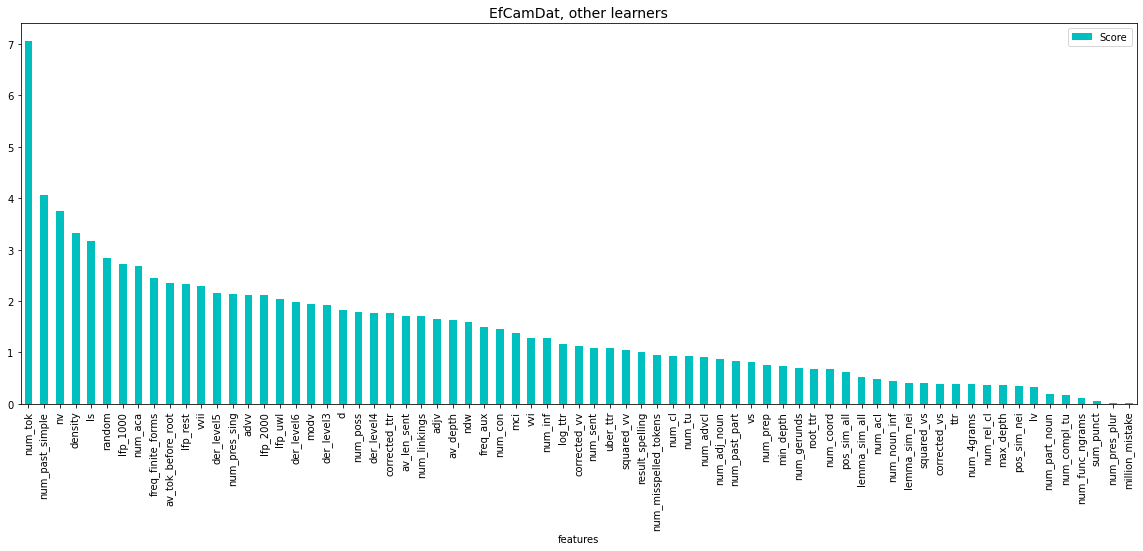

In [58]:
model = CatBoostClassifier(
    n_estimators = 786,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_ru, y_train_ru,
    eval_set=(X_test_ru, y_test_ru),
);
predictions = model.predict(X_test_ru)
print("Confusion Matrix:")
print(confusion_matrix(y_test_ru, predictions))
print("Classification Report")
print(classification_report(y_test_ru, predictions))

fi = model.get_feature_importance(Pool(X_test_ru, label=y_test_ru))
feature_score = pd.DataFrame(list(zip(X_test_ru.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, Russian learners", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**41 complexity features, EfCamDatRusData**

Confusion Matrix:
[[3815  192   35]
 [ 428  831   67]
 [ 111  117  124]]
Classification Report
              precision    recall  f1-score   support

          B1       0.88      0.94      0.91      4042
          B2       0.73      0.63      0.67      1326
          C1       0.55      0.35      0.43       352

    accuracy                           0.83      5720
   macro avg       0.72      0.64      0.67      5720
weighted avg       0.82      0.83      0.82      5720



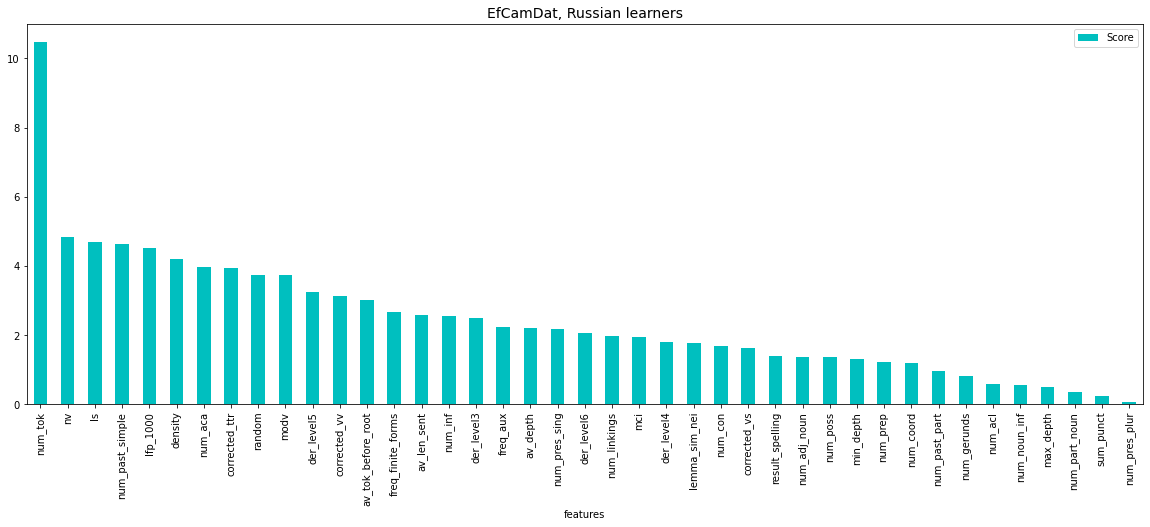

In [59]:
removed = ['lv',  'num_rel_cl','num_advcl','pos_sim_nei','pos_sim_all', 'lemma_sim_all', 'lfp_2000', 
           'lfp_rest', 'adjv', 'advv', 'num_4grams', 'ttr', 'root_ttr', 'log_ttr', 'uber_ttr', 'd',
           'vvi', 'squared_vv', 'vvii', 'lfp_uwl', 'vs', 'squared_vs','num_tu','num_compl_tu','num_misspelled_tokens','million_mistake',
           'num_sent', 'ndw', 'num_cl', 'num_func_ngrams']
for i in removed:
  X_ru = X_ru.drop(i, 1)
X_train_ru_d, X_test_ru_d, y_train_ru_d, y_test_ru_d = train_test_split(X_ru, y_ru, test_size=0.33, random_state=42)
model = CatBoostClassifier(
    n_estimators = 786,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_ru_d, y_train_ru_d,
    eval_set=(X_test_ru_d, y_test_ru_d),
);
predictions = model.predict(X_test_ru_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_ru_d, predictions))
print("Classification Report")
print(classification_report(y_test_ru_d, predictions))

fi = model.get_feature_importance(Pool(X_test_ru_d, label=y_test_ru_d))
feature_score = pd.DataFrame(list(zip(X_test_ru_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, Russian learners", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**5 complexity features, EfCamDatRusData**

Confusion Matrix:
[[3425  232   21]
 [ 517  635   51]
 [ 111  137   71]]
Classification Report
              precision    recall  f1-score   support

          B1       0.85      0.93      0.89      3678
          B2       0.63      0.53      0.58      1203
          C1       0.50      0.22      0.31       319

    accuracy                           0.79      5200
   macro avg       0.66      0.56      0.59      5200
weighted avg       0.77      0.79      0.78      5200



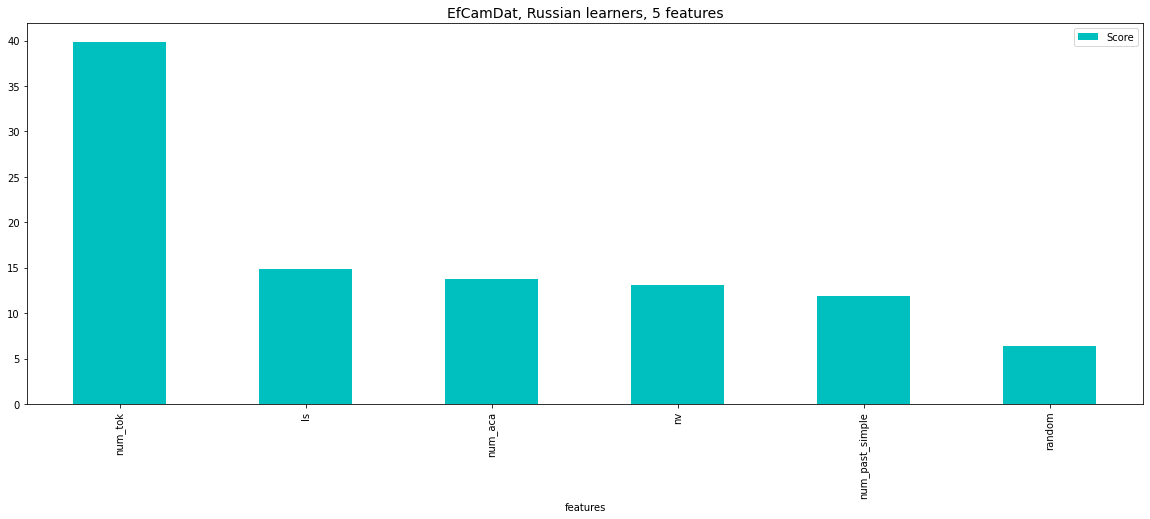

In [114]:
best = ['num_tok', 'num_past_simple','num_aca','nv','ls', 'random']
for i in X_ru.columns:
  if i not in best:
    X_ru = X_ru.drop(i, 1)
X_train_ru_d, X_test_ru_d, y_train_ru_d, y_test_ru_d = train_test_split(X_ru, y_ru, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 786,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_ru_d, y_train_ru_d,
    eval_set=(X_test_ru_d, y_test_ru_d),
);
predictions = model.predict(X_test_ru_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_ru_d, predictions))
print("Classification Report")
print(classification_report(y_test_ru_d, predictions))

fi = model.get_feature_importance(Pool(X_test_ru_d, label=y_test_ru_d))
feature_score = pd.DataFrame(list(zip(X_test_ru_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, Russian learners, 5 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**1 complexity feature, EfCamDatRusData**

In [69]:
best = ['num_tok']
for i in X_ru.columns:
  if i not in best:
    X_ru = X_ru.drop(i, 1)
X_train_ru_d, X_test_ru_d, y_train_ru_d, y_test_ru_d = train_test_split(X_ru, y_ru, test_size=0.3, random_state=42)
model = CatBoostClassifier(
    n_estimators = 76,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_ru_d, y_train_ru_d,
    eval_set=(X_test_ru_d, y_test_ru_d),
);
predictions = model.predict(X_test_ru_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_ru_d, predictions))
print("Classification Report")
print(classification_report(y_test_ru_d, predictions))

Confusion Matrix:
[[3443  234    1]
 [ 672  525    6]
 [ 112  204    3]]
Classification Report
              precision    recall  f1-score   support

          B1       0.81      0.94      0.87      3678
          B2       0.55      0.44      0.48      1203
          C1       0.30      0.01      0.02       319

    accuracy                           0.76      5200
   macro avg       0.55      0.46      0.46      5200
weighted avg       0.72      0.76      0.73      5200



**66 complexity features, EfCamDatOth data**

Confusion Matrix:
[[44777  1748   255]
 [ 4796  9074   652]
 [ 1132  1143  1720]]
Classification Report
              precision    recall  f1-score   support

          B1       0.88      0.96      0.92     46780
          B2       0.76      0.62      0.69     14522
          C1       0.65      0.43      0.52      3995

    accuracy                           0.85     65297
   macro avg       0.77      0.67      0.71     65297
weighted avg       0.84      0.85      0.84     65297



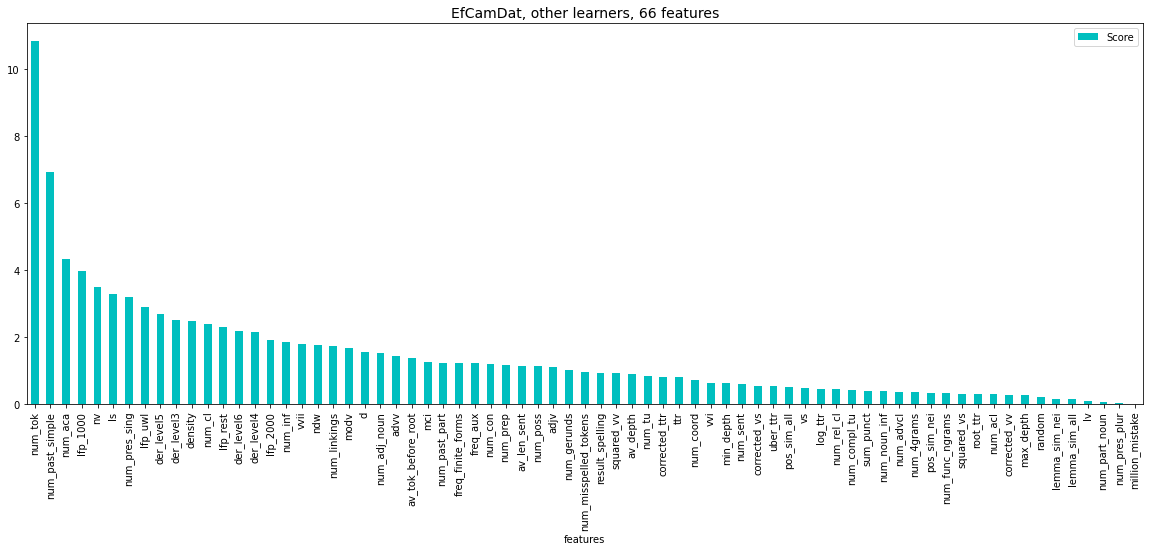

In [105]:
model = CatBoostClassifier(
    n_estimators = 654,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_oth, y_train_oth,
    eval_set=(X_test_oth, y_test_oth),
);
predictions = model.predict(X_test_oth)
print("Confusion Matrix:")
print(confusion_matrix(y_test_oth, predictions))
print("Classification Report")
print(classification_report(y_test_oth, predictions))

fi = model.get_feature_importance(Pool(X_test_oth, label=y_test_oth))
feature_score = pd.DataFrame(list(zip(X_test_oth.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, other learners, 66 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**41 complexity features, EfCamDatOth data**

Confusion Matrix:
[[49076  2062   258]
 [ 5386  9921   693]
 [ 1254  1328  1849]]
Classification Report
              precision    recall  f1-score   support

          B1       0.88      0.95      0.92     51396
          B2       0.75      0.62      0.68     16000
          C1       0.66      0.42      0.51      4431

    accuracy                           0.85     71827
   macro avg       0.76      0.66      0.70     71827
weighted avg       0.84      0.85      0.84     71827



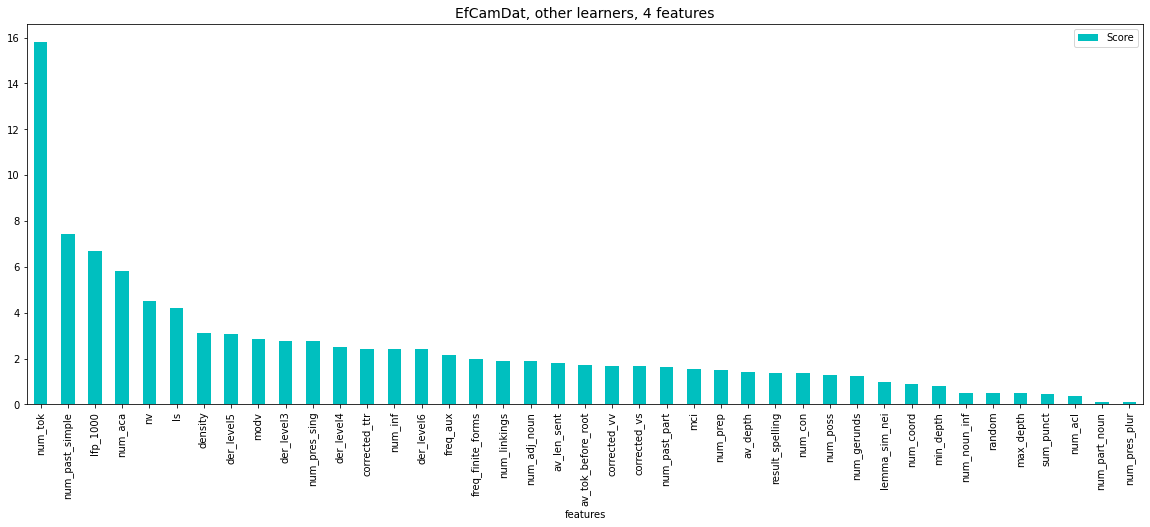

In [113]:
removed = ['lv',  'num_rel_cl','num_advcl','pos_sim_nei','pos_sim_all', 'lemma_sim_all', 'lfp_2000', 
           'lfp_rest', 'adjv', 'advv', 'num_4grams', 'ttr', 'root_ttr', 'log_ttr', 'uber_ttr', 'd',
           'vvi', 'squared_vv', 'vvii', 'lfp_uwl', 'vs', 'squared_vs','num_tu','num_compl_tu','num_misspelled_tokens','million_mistake',
           'num_sent', 'ndw', 'num_cl', 'num_func_ngrams']
for i in removed:
  X_oth = X_oth.drop(i, 1)
X_train_oth_d, X_test_oth_d, y_train_oth_d, y_test_oth_d = train_test_split(X_oth, y_oth, test_size=0.33, random_state=42)
model = CatBoostClassifier(
    n_estimators = 654,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_oth_d, y_train_oth_d,
    eval_set=(X_test_oth_d, y_test_oth_d),
);
predictions = model.predict(X_test_oth_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_oth_d, predictions))
print("Classification Report")
print(classification_report(y_test_oth_d, predictions))

fi = model.get_feature_importance(Pool(X_test_oth_d, label=y_test_oth_d))
feature_score = pd.DataFrame(list(zip(X_test_oth_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, other learners, 4 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**5 complexity features, EfCamDatOth data**

Confusion Matrix:
[[48236  2861   299]
 [ 7027  8086   887]
 [ 1201  1918  1312]]
Classification Report
              precision    recall  f1-score   support

          B1       0.85      0.94      0.89     51396
          B2       0.63      0.51      0.56     16000
          C1       0.53      0.30      0.38      4431

    accuracy                           0.80     71827
   macro avg       0.67      0.58      0.61     71827
weighted avg       0.78      0.80      0.79     71827



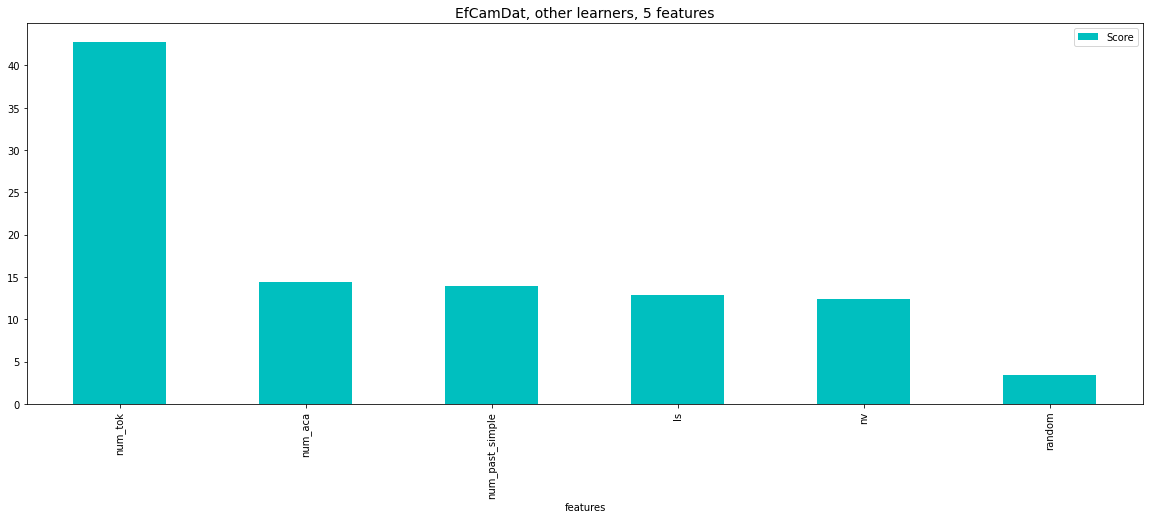

In [120]:
best = ['num_tok', 'num_past_simple','num_aca','nv','ls', 'random']
for i in X_oth.columns:
  if i not in best:
    X_oth = X_oth.drop(i, 1)
X_train_oth_d, X_test_oth_d, y_train_oth_d, y_test_oth_d = train_test_split(X_oth, y_oth, test_size=0.33, random_state=42)
model = CatBoostClassifier(
    n_estimators = 354,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_oth_d, y_train_oth_d,
    eval_set=(X_test_oth_d, y_test_oth_d),
);
predictions = model.predict(X_test_oth_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_oth_d, predictions))
print("Classification Report")
print(classification_report(y_test_oth_d, predictions))

fi = model.get_feature_importance(Pool(X_test_oth_d, label=y_test_oth_d))
feature_score = pd.DataFrame(list(zip(X_test_oth_d.dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("EfCamDat, other learners, 5 features", fontsize = 14)
ax.set_xlabel("features")
plt.show()

**1 complexity feature, EfCamDatOth data**

In [76]:
best = ['num_tok']
for i in X_oth.columns:
  if i not in best:
    X_oth = X_oth.drop(i, 1)
X_train_oth_d, X_test_oth_d, y_train_oth_d, y_test_oth_d = train_test_split(X_oth, y_oth, test_size=0.33, random_state=42)
model = CatBoostClassifier(
    n_estimators = 354,
    depth = 6,
    learning_rate = 0.2,
    l2_leaf_reg = 4,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
model.fit(
    X_train_oth_d, y_train_oth_d,
    eval_set=(X_test_oth_d, y_test_oth_d),
);
predictions = model.predict(X_test_oth_d)
print("Confusion Matrix:")
print(confusion_matrix(y_test_oth_d, predictions))
print("Classification Report")
print(classification_report(y_test_oth_d, predictions))

Confusion Matrix:
[[48360  2988    48]
 [ 8734  7142   124]
 [ 1223  3105   103]]
Classification Report
              precision    recall  f1-score   support

          B1       0.83      0.94      0.88     51396
          B2       0.54      0.45      0.49     16000
          C1       0.37      0.02      0.04      4431

    accuracy                           0.77     71827
   macro avg       0.58      0.47      0.47     71827
weighted avg       0.74      0.77      0.74     71827

